# Replicating portfolios 
#### Simulating a mortgage portfolio

https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

1000 mortgages each with a notional of 1 mln EUR.
Generate them using the real evolution of interest rates over the last 30 years.

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month.


### Predictive modelling for market risk in the banking book
#### Applied Operational Research in Business consulting
EY

#### Behavioral modelling in the banking book

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data. 

In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers will change there behavious towards the interest rates that they want to lock in their mortgages based on assumptions they have about the economy and especially the forward interest rates and the prices offered by the bank. 

The DNB loan level data may say something here...




In [7]:
import os

# Get the current working directory
cwd = os.getcwd()

import sys
sys.path.insert(0, "..") 
cwd

'c:\\Users\\M\\SkyDrive\\Documents\\GitHub\\rlalm\\notebooks'

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..") 

import openpyxl
import pandas as pd
import numpy_financial as npf
from  src.visualization import visualize


%matplotlib inline

pd.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'src.visualization'

In [2]:
# initially prepayment rate and probability of default is modelled as a constant
pre_payment_rate = 0.4
pdf = 0.15
coupon_rate = 0.02 # Based on the market rates, on average 4.5%

# Growth rate of new business is a fixed percentage (with an average lifespan of 8 years - growth rate should be more then 10%)
# Maybe I can get this from the yearly statements
gr = 0.05

#### Mortagage interest development

Interest data on mortgages have been downloaded from the dutch central bank statistics site. 

https://www.dnb.nl/statistieken/data-zoeken/#/details/deposito-s-en-leningen-van-mfi-s-aan-huishoudens-rentepercentages-gecorrigeerd-voor-breuken-maand/dataset/efba2d4e-fb53-49a8-a1fe-d5ee3263e14c/resource/8d3ccc86-8396-43b8-a18b-5ba293f01c1d


In [56]:
df_i = pd.read_excel("../data/raw/interest.xlsx")
# select only mortgages of verious fixed interest periods
df_i = df_i.query("Instrument == 'Woninghypotheken - Totaal ' " )
df_i = df_i.query("Stroomtype == 'Nieuwe contracten '")
df_i = df_i.query("RenteVastPeriode != 'totaal'")
df_i = df_i[['RenteVastPeriode','Periode ','waarde']]
# subset columns
df_i.columns = ['fixed_period', 'period', 'interest']
df_i['fixed_period'] = df_i['fixed_period'].replace(
    {'> 1 jaar en <= 5 jaar * '  :   '1>5 years',
     '> 5 jaar en <= 10 jaar * ' :  '5>10 years',
     'Variabel en <= 1 jaar * '  : '<= 1 year', 
     '> 10 jaar * '              :  '> 10 years'
    }
)
df_i['ratedate'] = pd.to_datetime(
                          df_i["period"],
                          format='%Y-%m'
                   )
df_i = df_i.set_index('ratedate')

df_i = df_i.sort_values(by = 'ratedate' )
df_i['fixed_period'] = df_i['fixed_period'].astype("category")
df_i['fixed_period']  = df_i['fixed_period'].cat.set_categories(['<= 1 year', '1>5 year', '5>10 year', '> 10 year' ], ordered=True)


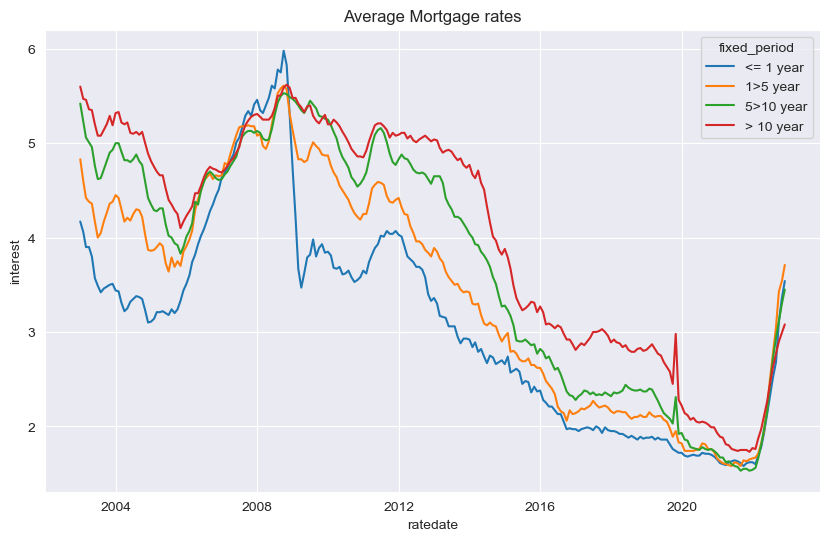

In [57]:
visualize.lineplot(
    df_i, 
    x = df_i.index, 
    x_label = 'Rate Date',
    y = 'interest',     
    hue = 'fixed_period',
    title="Average Mortgage rates" )



In [108]:
# De Volksbank Annual Report 
# initialize data of lists.

data = {'year':  [  2021,  2020,  2019,  2018,  2017,  2016,   2015,  2014,  2013,  2012,  2011 ],
        'loans': [ 50727, 50542, 50542, 50461, 50536, 48593,  49217, 52834, 53405, 49341, 51263 ] }
  
# Create DataFrame
df = pd.DataFrame(data)
df = df.sort_values(by = ['year'] )
df['growth'] = df['loans'].pct_change()
df = df.set_index('year')
df['prepayments'] =  - round((pre_payment_rate / 100) * df['loans'],4)
df['lgd']  = - round((pdf / 100) * df['loans'],0)
df['mortgages'] = round(df.loans / 200,0)
df['net_in_outflow'] = round((df['loans'].shift(-1) - ( df['loans'] + df['prepayments'] + df['lgd'] )   ) )
df.style.format(
    na_rep='',
    formatter =     
    {    
        "loans"       : "{:,.0f}",
        "growth"      : "{:0.2%}",        
        "mortgages"   : "{:,.0f}",
        "prepayments" : "{:,.0f}",    
        "lgd"         : "{:,.0f}", 
        "net_in_outflow"         : "{:,.0f}", 
    }
    
)

,loans,growth,prepayments,lgd,mortgages,net_in_outflow
year,,,,,,
2011,"51,263",,-205,-77,256,"-1,640"
2012,"49,341",-3.75%,-197,-74,247,"4,335"
2013,"53,405",8.24%,-214,-80,267,-277
2014,"52,834",-1.07%,-211,-79,264,"-3,327"
2015,"49,217",-6.85%,-197,-74,246,-353
2016,"48,593",-1.27%,-194,-73,243,"2,210"
2017,"50,536",4.00%,-202,-76,253,203
2018,"50,461",-0.15%,-202,-76,252,359
2019,"50,542",0.16%,-202,-76,253,278


In [114]:
df.dtypes

loans               int64
growth            float64
prepayments       float64
lgd               float64
mortgages         float64
net_in_outflow    float64
dtype: object

In [127]:
# Randomly generate 50.000.000 mortgage loans, with a tenor of 30 years, in 4 different categories
loan = df.iloc[0]['loans']
tenor = 30


51263.0


In [122]:
loans

year
2011    51263
Name: loans, dtype: int64

In [118]:
num_categories = 4 # the number of categories you want to divide x into
category_likelihoods = [0.1, 0.4, 0.4, 0.1] # the likelihood of each category, is in reality not fixed

# define a function to generate the counts for a single value of x
def generate_categories(x):
    x = int (x)
    # generate a random factor for each category using beta distribution
    beta_factors = np.random.beta(1, 2, num_categories)

    # multiply the likelihood of each category by its corresponding random factor
    category_likelihoods_with_random_factor = category_likelihoods * beta_factors

    # normalize the likelihoods to ensure that they sum up to 1
    category_likelihoods_with_random_factor /= np.sum(category_likelihoods_with_random_factor)

    # generate a random distribution using categorical distribution
    weights = np.random.choice(num_categories, size=x, p=category_likelihoods_with_random_factor)

    # count the number of occurrences of each category
    unique, counts = np.unique(weights, return_counts=True)

    # pad the counts array with zeros for missing categories
    counts = np.pad(counts, (0, num_categories - len(counts)), mode='constant')

    return counts

# apply the function to the 'x' column of the dataframe and store the results in new columns
df[['<= 1 Year', '1-5 Years', '5>10 Years', '> 10 Years']] = df['mortgages'].apply(generate_categories).tolist()

# print the resulting dataframe
print(df)

      loans    growth  prepayments   lgd  mortgages  net_in_outflow  \
year                                                                  
2011  51263       NaN      -205.05 -77.0      256.0         -1640.0   
2012  49341 -3.75e-02      -197.36 -74.0      247.0          4335.0   
2013  53405  8.24e-02      -213.62 -80.0      267.0          -277.0   
2014  52834 -1.07e-02      -211.34 -79.0      264.0         -3327.0   
2015  49217 -6.85e-02      -196.87 -74.0      246.0          -353.0   
2016  48593 -1.27e-02      -194.37 -73.0      243.0          2210.0   
2017  50536  4.00e-02      -202.14 -76.0      253.0           203.0   
2018  50461 -1.48e-03      -201.84 -76.0      252.0           359.0   
2019  50542  1.61e-03      -202.17 -76.0      253.0           278.0   
2020  50542  0.00e+00      -202.17 -76.0      253.0           463.0   
2021  50727  3.66e-03      -202.91 -76.0      254.0             NaN   

      <= 1 Year  1-5 Years  5>10 Years  > 10 Years  
year                   

Non Maturity Deposits

#### Core vs Non Core balances
For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)